In [42]:
from importlib.metadata import version
import nltk
import tensorflow as tf
import summa
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings("ignore", category = UserWarning , module = 'bs4')

print('완료')

완료


# 데이터 수집하기

In [43]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [44]:
#10개 추출해보기
data.sample(10)

,headlines,text
29506,Muscles thought to be exclusively human found ...,A study on apes has found that seven muscles t...
88213,Free tools to unlock WannaCry without ransom r...,Researchers have released tools to help people...
77568,India to play record 23 home matches in 4 mont...,Team India will play a record 23 home matches ...
76835,Russia making AI-powered missile that selects ...,Russian firm Tactical Missiles Corporation is ...
1549,No one is more committed to Indian cricket tha...,Following India's ODI series victory against A...
50733,IndiGo profit rises 56.4% to Ã¢ÂÂ¹762 crore i...,IndiGo's parent InterGlobe Aviation on Tuesday...
37075,Poster refers to MP CM Shivraj Chouhan as Prim...,A poster showing Madhya Pradesh Chief Minister...
75162,Britons sentenced to caning in Singapore for s...,Three British men have been sentenced up to 6-...
45892,Biggest myth about actors is they throw tantru...,Parineeti Chopra has said the biggest myth tha...
22311,Jonty Rhodes set to participate in surfing eve...,Former South African cricketer Jonty Rhodes is...


text를 본문, headlines를 요약된 데이터로 삼아서 모델학습 진행

In [45]:
print('전체샘플수', (len(data)))

전체샘플수 98401


# 데이터 전처리

In [46]:
print('headline 열에서 중복배제한 샘플 수', data['headlines'].nunique())
print('summary 열에서 중복배제한 샘플 수', data['text'].nunique())

headline 열에서 중복배제한 샘플 수 98280
summary 열에서 중복배제한 샘플 수 98360


In [47]:
#중복샘플제거
#inplace = True로 설정하면 DF타입값을 리턴하지 않고 DATA내부를 직접적으로 바꿈
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플 수', (len(data)))

전체 샘플 수 98360


In [48]:
#null값 있는지 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


텍스트 정규화와 불용어 제거를 하겠습니다.

In [49]:
#정규화 사전 가져오기

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [50]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

print('불용어개수', len(stopwords.words('english')))
print(stopwords.words('english'))

불용어개수 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
#데이터전처리함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() #텍스트 소문자화
    sentence = BeautifulSoup(sentence, 'lxml').text #html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(' ')]) #약어정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    #불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    #불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

print('완료')

완료


In [52]:
#전처리함수 잘 작동하는지 확인

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  
# 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [53]:
#전체 text데이터에 대한 전처리
clean_text = []

for i in data['text']:
    text = preprocess_sentence(i)
    clean_text.append(text)
    
#전 처리 후 출력
print('text 전 처리 후 결과', clean_text[:3])

text 전 처리 후 결과 ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history']


In [54]:
#headline 전처리는 불용어제거를 수행하지 않는 의미로 false추가
# 전체 headline 데이터에 대한 전처리
clean_headline = []

for i in data['headlines']:
    text2 = preprocess_sentence(i, remove_stopwords=False)
    clean_headline.append(text2)

print("headline 전처리 후 결과: ", clean_headline[:3])

headline 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak']


In [55]:
#데이터들을 데이터프레임에 재저장, empty값은 null로 대체

data['text'] = clean_text
data['headlines'] = clean_headline

#빈 값을 null로 변환
data.replace('', np.nan, inplace=True)

print('완료')

완료


In [56]:
#null값 생겼는지 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

텍스트의 최소 길이 1
텍스트의 최대 길이 60
텍스트의 평균 길이 35.09968483123221
요약의 최소 길이 1
요약의 최대 길이 16
요약의 평균 길이 9.299532330215534


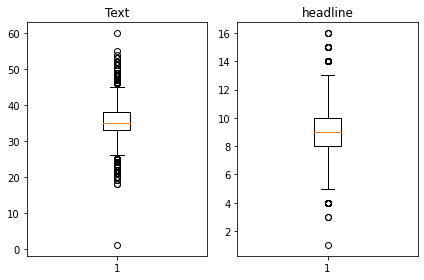

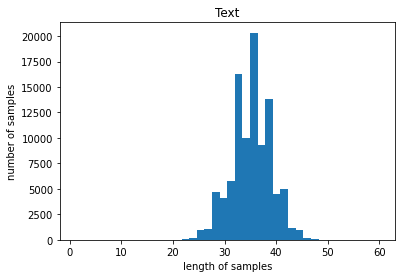

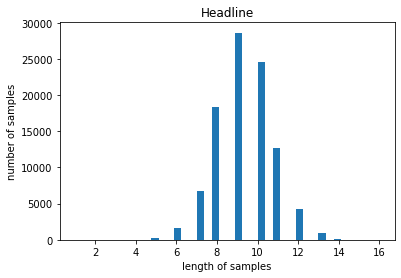

In [57]:
#훈련에 사용할 샘플의 최대 길이 정하기

#길이 분포 출력


text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 {}'.format(np.mean(text_len)))
print('요약의 최소 길이 {}'.format(np.min(headline_len)))
print('요약의 최대 길이 {}'.format(np.max(headline_len)))
print('요약의 평균 길이 {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headline_len)
plt.title('headline')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headline')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [58]:
#text와 요약의 적절한 최대 길이 임의로 정하기
#헤드라인이 노드 데이터의 평균값보다 2배커서 최대값도 2배 임의로 줬습니다.
text_max_len = 45
headline_max_len = 14
print('완료')

완료


In [59]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt += 1
    print('전체 샘플 중 길이가 %s 이하인 샘플비율 %s'%(max_len, (cnt / len(nested_list))))
print('완료')

완료


In [60]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플비율 0.9967771451809678
전체 샘플 중 길이가 14 이하인 샘플비율 0.9997763318422123


In [61]:
#거의 대부분 포함하고있긴하지만 그래도 역치이상의 값을 지우겠습니다.
#Text와 headline을 담고 있는 data 데이터프레임을 
#위에서 임의로 정의한 text_max_len과 headline_max_len의 길이보다 큰 샘플을 제외하는 코드

# 'Text'와 'headline' 컬럼의 길이가 지정한 최대 길이보다 큰 샘플을 제외
data = data[data.apply(lambda x: len(x['text'].split()) <= text_max_len and len(x['headlines'].split()) <= headline_max_len, axis=1)]


print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98021


In [62]:
#headline데이터에는 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [63]:
#모델학습을 위해 인코더,디코더 입력,레이블을 넘파이 타입으로 저장
encoder_input = np.array(data['text']) #인코더의 입력
decoder_input = np.array(data['decoder_input']) #디코더 입력
decoder_target = np.array(data['decoder_target']) #디코더의 레이블
print('완료')

완료


훈련데이터와 테스트데이터를 분리하겠습니다.

In [64]:
#encoder_input 과 크기와 형태가 같은 순서가 섞인 정수 시퀀스
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[25702 78898 67848 ... 31757 59365 19209]


In [65]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('완료')

완료


In [66]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터 수', n_of_val)

테스트 데이터 수 19604


In [67]:
encoder_input_train = encoder_input[:-n_of_val] #- 붙혀서 n_of_val만큼 제외
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:] #n_of_val만큼 뒤에서 선택
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))


훈련 데이터의 개수 : 78417
훈련 레이블의 개수 : 78417
테스트 데이터의 개수 : 19604
테스트 레이블의 개수 : 19604


In [68]:
#단어 집합 만들기 
src_tokenizer =Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train) #단어집합생성

In [69]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) #단어의 수
rare_cnt = 0 #빈도수가 역치보다 작은 단어 카운트
total_freq = 0 #전체 단어 빈도수 총 합
rare_freq = 0 #등장빈도수가 역치보다 낮은 단어들의 빈도수 총합

#단어와 빈도수를 키와 밸류로 받음
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    #단어의 등장 빈도수가 역치보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69515
등장 빈도가 6번 이하인 희귀 단어의 수: 47393
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22122
단어 집합에서 희귀 단어의 비율: 68.17665252103863
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4894172814223543


In [70]:
#노드를 따라가서 8000으로 지정했습니다.
#원래는 #단어 집합의 크기 - 등장빈도가 6번 이하인 희귀 단어의 수를 src_vocab으로 설정하여야 함
#등장빈도가 6회 이하인 단어들은 훈련 데이터 에서 제거
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train) #단어집합 재생성

In [71]:
#텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#샘플 출력해봅시다
print(encoder_input_train[:3])

[[383, 252, 184, 44, 39, 83, 2236, 1109, 1056, 753, 484, 6613, 82, 99, 1206, 449, 437, 464, 901, 2236, 775, 237, 1, 1768, 129, 1792, 2840, 1709, 3057, 484, 226, 111, 171, 10, 1047], [79, 1651, 1881, 203, 66, 378, 312, 7, 27, 3377, 164, 1651, 1725, 180, 15, 2551, 426, 71, 1297, 1196, 5809, 953, 15, 2568, 15, 2701, 1196], [1710, 2494, 2592, 1098, 823, 1537, 450, 1098, 147, 647, 2494, 1098, 697, 301, 19, 23, 3270, 136, 105, 2, 3951, 697, 92, 301, 2494]]


decoder도 따로 해줍니다.

In [72]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [73]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30050
등장 빈도가 5번 이하인 희귀 단어의 수: 19637
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10413
단어 집합에서 희귀 단어의 비율: 65.34775374376039
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.64092694695022


In [74]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 56, 291, 442, 149, 684, 6, 316, 600, 7], [1, 817, 108, 75, 6, 4], [1, 1123, 6, 4, 386, 12, 52], [1, 58, 170, 276, 306], [1, 297, 79, 117, 218]]
target
decoder  [[56, 291, 442, 149, 684, 6, 316, 600, 7, 2], [817, 108, 75, 6, 4, 2], [1123, 6, 4, 386, 12, 52, 2], [58, 170, 276, 306, 2], [297, 79, 117, 218, 2]]


In [75]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 15
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 78402
훈련 레이블의 개수 : 78402
테스트 데이터의 개수 : 19603
테스트 레이블의 개수 : 19603


In [76]:
#샘플들의 길이가 각각 다르기 때문에 패딩으로 같게 맞춰줍니다.
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headline_max_len, padding='post')
print('완료')

완료


# 모델설계

In [77]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)


In [78]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [79]:
#디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

#모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 45, 128)      1024000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 45, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 어텐션 매커니즘 사용하기

In [80]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 45, 128)      1024000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 45, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [81]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=10)

Epoch 1/10
307/307 [==============================] - 29s 77ms/step - loss: 3.3581 - val_loss: 3.0778
Epoch 2/10
307/307 [==============================] - 23s 75ms/step - loss: 2.9373 - val_loss: 2.7957
Epoch 3/10
307/307 [==============================] - 24s 77ms/step - loss: 2.6994 - val_loss: 2.6212
Epoch 4/10
307/307 [==============================] - 24s 77ms/step - loss: 2.5413 - val_loss: 2.5119
Epoch 5/10
307/307 [==============================] - 23s 76ms/step - loss: 2.4218 - val_loss: 2.4201
Epoch 6/10
307/307 [==============================] - 23s 76ms/step - loss: 2.3242 - val_loss: 2.3472
Epoch 7/10
307/307 [==============================] - 23s 76ms/step - loss: 2.2415 - val_loss: 2.2933
Epoch 8/10
307/307 [==============================] - 23s 76ms/step - loss: 2.1706 - val_loss: 2.2471
Epoch 9/10
307/307 [==============================] - 23s 76ms/step - loss: 2.1084 - val_loss: 2.2028
Epoch 10/10
307/307 [==============================] - 23s 76ms/step - loss: 2.053

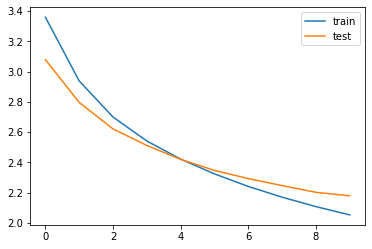

In [82]:
# loss가 줄어드는것 시각화 하겠습니다.
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [83]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 헤드라인 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 헤드라인 단어 집합에서 정수 -> 단어를 얻음

print('완료')

완료


seq2seq는 훈련과 실제동작(인퍼런스)의 방식이 다르므로 모델 설계를 별개로 진행해야합니다.(정답이 주어지지않으므로)
인퍼런스 모델 설계하겠습니다.

In [84]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('완료')

완료


In [85]:
# 어텐션 메커니즘을 이용한 출력층 설계
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('완료')

완료


In [86]:
#인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('완료')

완료


# 모델 테스트

In [87]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('완료')

# # 'sostoken'을 딕셔너리에 추가하는 예시
# if 'sostoken' not in tar_word_to_index:
#     tar_word_to_index['sostoken'] = 10000

# if 'eostoken' not in tar_word_to_index:
#     tar_word_to_index['eostoken'] = 10001


완료


In [88]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : responding indian dairy cooperative amul poster congress mp shashi tharoor saturday tweeted honoured feel like rex amul tweeted poster leader captioned anyone usage word tharoor used word recent tweet writing style 
실제 요약 : tharoor responds to poster 
예측 요약 :  tharoor trolled for calling her


원문 : european japanese space agencies building joint mission solar system smallest least planet two spacecraft one scheduled launch october would reach orbit seven years later temperature third mission would build nasa missions 
실제 요약 : europe japan plan joint mission to for 
예측 요약 :  solar to launch solar system


원문 : qatar airways bali flight carrying passengers made emergency landing hyderabad airport saturday one pilots suffered heart attack thirty four year old pilot complained severe pain heart rushed hospital flight landed condition said stable 
실제 요약 : pilot heart attack flight makes emergency landing 
예측 요약 :  flight makes emergency landing after emergency landing


원문 : uk based s

# Summa를 이용해서 추출적 요약해보기

In [89]:
import requests
from summa.summarizer import summarize

In [90]:
#매트릭스 시놉시스 다운로드
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [91]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [92]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


## summarize의 인자로 사용된는 값들

text (str) : 요약할 테스트.

ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값

words (int or None, optional) – 출력에 포함할 단어 수.

만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.

split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환